<a href="https://colab.research.google.com/github/kiran-pyt/ERA1S5/blob/main/S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms,models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [50]:
train_transform=transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081))
])
test_transform=transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081))
])

TRAIN & TEST DATASET DOWNLOAD--SPLIT

In [51]:
train=datasets.MNIST('./data',train=True,download=True,transform=train_transform)
test=datasets.MNIST('./data',train=False,download=True,transform=test_transform)

In [52]:
print("Number of train sample {}".
       format(len(train)))

print("Number of Test samples {}".
       format(len(test)))



Number of train sample 60000
Number of Test samples 10000


CHECK Cuda is Available

In [53]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [54]:
SEED=1
# For reproducibilty
torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


In [55]:
train_data = train.train_data
train_data=train.transform(train_data.numpy())
print('[Train]')
print(' -Numpy Shape:',train.train_data.cpu().numpy().shape)
print(' -Tensor Shape',train.train_data.size())
print(' -min',torch.min(train_data))
print(' -max',torch.max(train_data))
print(' -std',torch.std(train_data))
print(' -var',torch.var(train_data))

[Train]
 -Numpy Shape: (60000, 28, 28)
 -Tensor Shape torch.Size([60000, 28, 28])
 -min tensor(-0.4242)
 -max tensor(2.8215)
 -std tensor(1.0000)
 -var tensor(1.0001)


In [56]:
dataiter=iter(train_loader)
images,lables=next(dataiter)

print(images.shape)
print(lables.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


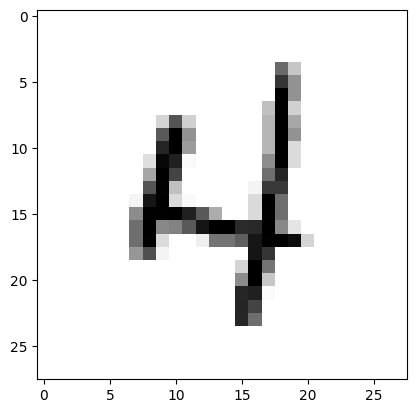

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

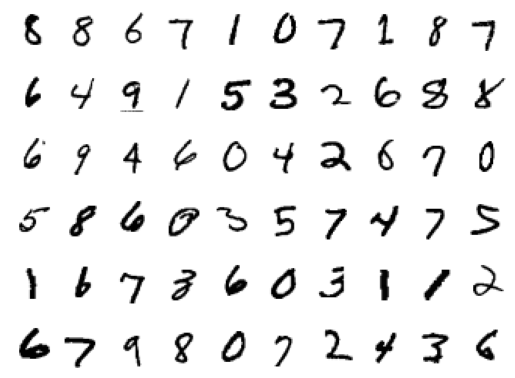

In [58]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [59]:
simple_transforms=transforms.Compose([
    transforms.ToTensor()
])

exp=datasets.MNIST('./data',train=True,transform=simple_transforms)
exp_data=exp.train_data
exp_data=exp.transform(exp_data.numpy())


print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


THE MODEL

In [60]:
class FDNN(nn.Module):
  def __init__(self):
    super(FDNN,self).__init__()
    self.convblock1=nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,     #Feature Map = (28,28)
                  kernel_size=(3,3),
                  padding=1,
                  bias=False),
                  nn.ReLU(),
                  nn.BatchNorm2d(8),
                  nn.Dropout(0.1)
                  


            
        )
    self.convblock2=nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=8,
                  kernel_size=(3,3),
                  padding=1,
                  bias=False),
                  nn.ReLU(),
                  nn.BatchNorm2d(8),
                  #nn.Dropout(0.1)
    )

    self.pool22=nn.MaxPool2d(2,2) 

    self.convblock3=nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,
                                 kernel_size=(3,3),padding=1,
                                 bias=False),
                                 nn.ReLU(),
                                 nn.BatchNorm2d(16),
                                 nn.Dropout(0.1)
                      
    )
    
    self.convblock4=nn.Sequential(
        nn.Conv2d(
            in_channels=16,out_channels=16,
            kernel_size=(3,3),
            padding=1,
            bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)
        )
    
    self.pool44=nn.MaxPool2d(2,2) 
    
    self.convblock5=nn.Sequential(
        nn.Conv2d(
            in_channels=16,out_channels=32,
            kernel_size=(3,3),
            padding=1,
            bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1)
            

        )
    self.convblock6=nn.Sequential(
        nn.Conv2d(
            in_channels=32,out_channels=32,
            kernel_size=(3,3),
            padding=1,
            bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1)
            

        )
    self.pool66=nn.MaxPool2d(2,2) 
    ## Last layer
    self.convblock7=nn.Sequential(
        nn.Conv2d(
            in_channels=32,out_channels=10,
            kernel_size=(1,1),
            padding=0,
            bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(10),
            

        )
    self.gap = nn.Sequential(
    nn.AvgPool2d(kernel_size=3)
    )
  
  def forward(self, x):

    x=self.convblock1(x)
    x=self.convblock2(x)
    x=self.pool22(x)
    x= self.convblock3(x)
    x=self.convblock4(x)
    x=self.pool44(x)
    x= self.convblock5(x)
    x=self.convblock6(x)
    x=self.pool66(x)
    x=self.convblock7(x)
    x = self.gap(x)
    x = x.view(-1, 10)
    return F.log_softmax(x, dim=-1)

      
      
    


In [61]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = FDNN().to(device)
summary(model, input_size=(1, 28,28))

Available processor cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         MaxPool2d-8            [-1, 8, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           1,152
             ReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
          Dropout-12           [-1, 16, 14, 14]               0
           Conv2d-13           [-1, 16, 14, 14]           2,304
             R

In [62]:
train_losses=[]
test_losses=[]
train_acc=[]
test_acc=[]

def train(model,device,train_loader,optimizer,epoch):
  model.train()
  pbar=tqdm(train_loader)
  correct=0
  processed=0
  for batch_idx,(data,traget) in enumerate(pbar):
    data,traget=data.to(device),traget.to(device)
    optimizer.zero_grad()
    y_pred=model(data)
    loss=F.nll_loss(y_pred,traget)
    train_losses.append(loss)
    loss.backward()
    optimizer.step()
    pred=y_pred.argmax(dim=1,keepdim=True)
    correct+=pred.eq(traget.view_as(pred)).sum().item()
    processed+=len(data)

    pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


     
      

       







In [63]:
model =  FDNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0559193454682827 Batch_id=468 Accuracy=92.59: 100%|██████████| 469/469 [00:21<00:00, 21.98it/s]



Test set: Average loss: 0.0936, Accuracy: 9702/10000 (97.02%)

EPOCH: 1


Loss=0.09254345297813416 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:19<00:00, 23.74it/s]



Test set: Average loss: 0.0529, Accuracy: 9828/10000 (98.28%)

EPOCH: 2


Loss=0.017195185646414757 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:19<00:00, 24.03it/s]



Test set: Average loss: 0.0411, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.05199446156620979 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:20<00:00, 23.08it/s]



Test set: Average loss: 0.0297, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.04293607175350189 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0256, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.043954480439424515 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:19<00:00, 23.47it/s]



Test set: Average loss: 0.0254, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.057114552706480026 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:20<00:00, 23.40it/s]



Test set: Average loss: 0.0263, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.005740599241107702 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0246, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.00821880716830492 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:20<00:00, 22.59it/s]



Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.04868203029036522 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.02972210943698883 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.86it/s]



Test set: Average loss: 0.0232, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.01585386134684086 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.72it/s]



Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.01575123704969883 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:20<00:00, 22.92it/s]



Test set: Average loss: 0.0261, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.010778897441923618 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:19<00:00, 23.54it/s]



Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

EPOCH: 14


Loss=0.017154911532998085 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:21<00:00, 22.25it/s]



Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.09433756023645401 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:21<00:00, 21.69it/s]



Test set: Average loss: 0.0224, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.012812075205147266 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.003408950986340642 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:19<00:00, 23.50it/s]



Test set: Average loss: 0.0212, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


Loss=0.037918295711278915 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s]



Test set: Average loss: 0.0214, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.030286850407719612 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:21<00:00, 21.74it/s]



Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

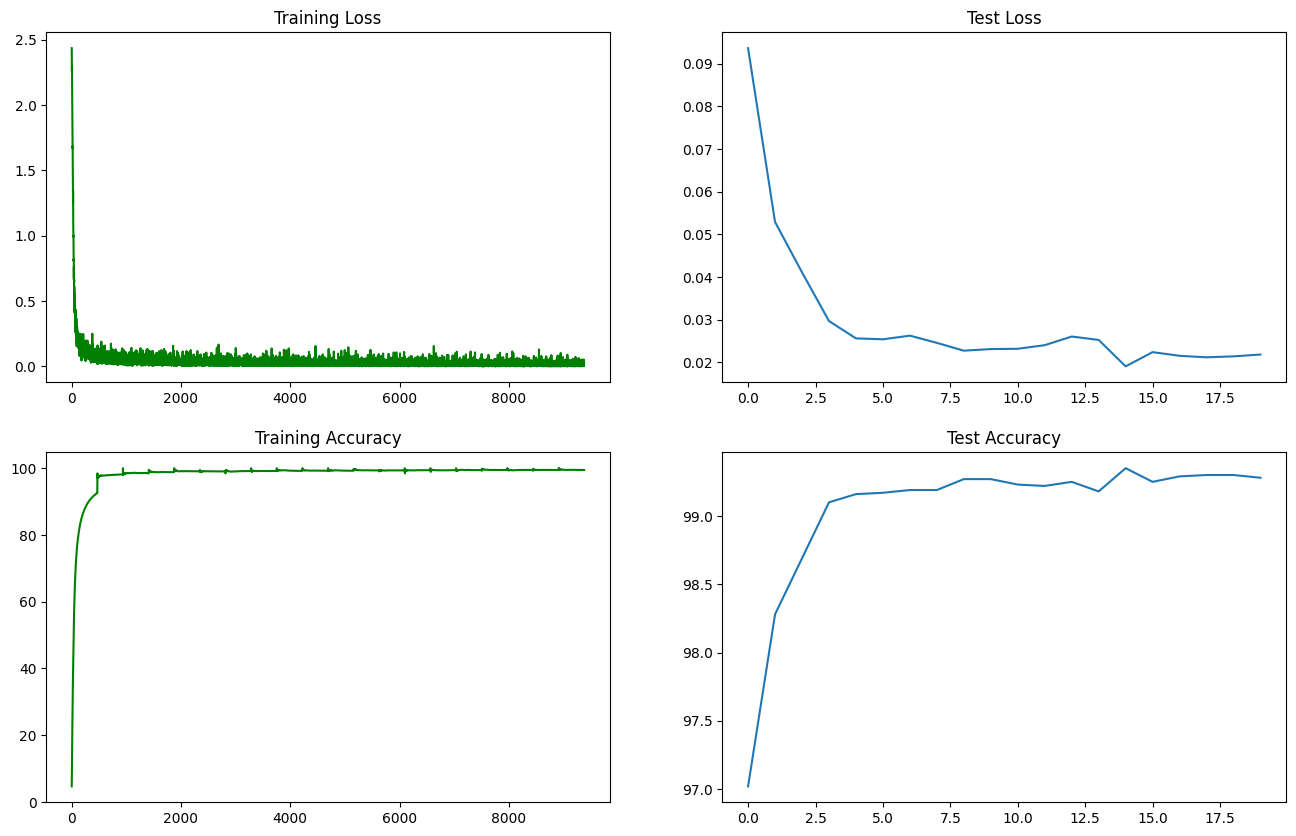

In [64]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in 
train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")